## 20-2. 시맨틱 세그멘테이션 데이터셋

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
            RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(              # 입력이미지를 224X224로 resize
                width=224,
                height=224
            )
        ])
    
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
        Resize(
            width=224,
            height=224
        )
    ])

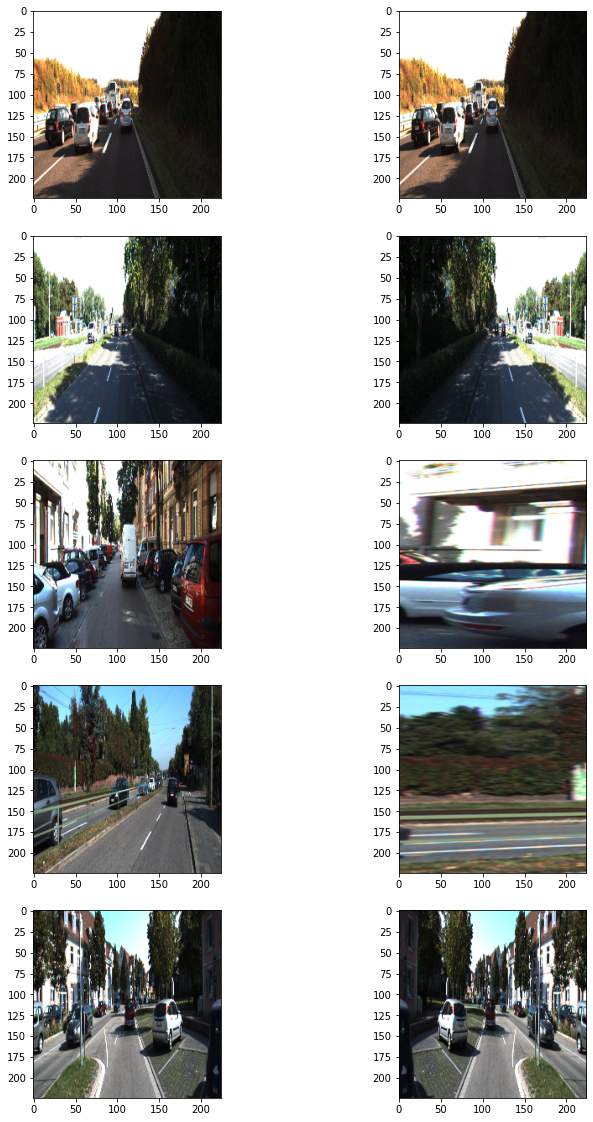

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/node_data/GD07/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
        
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs
        
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 20-3. 시맨틱 세그멘테이션 모델

In [6]:
def build_model(input_shape=(224, 224, 3)):
    input_image = Input(shape=input_shape, dtype='float32', name='input_image')
    
    conta = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='contracting_block1_conv1')(input_image)
    conta = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='contracting_block1_conv2')(conta)
    cont1 = MaxPooling2D(pool_size=(2, 2), strides=2, name='contracting_block1_pooling')(conta)
    
    contb = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='contracting_block2_conv1')(cont1)
    contb = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='contracting_block2_conv2')(contb)
    cont2 = MaxPooling2D(pool_size=(2, 2), strides=2, name='contracting_block2_pooling')(contb)
    
    contc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='contracting_block3_conv1')(cont2)
    contc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='contracting_block3_conv2')(contc)
    cont3 = MaxPooling2D(pool_size=(2, 2), strides=2, name='contracting_block3_pooling')(contc)
    
    contd = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='contracting_block4_conv1')(cont3)
    contd = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='contracting_block4_conv2')(contd)
    cont4 = MaxPooling2D(pool_size=(2, 2), strides=2, name='contracting_block4_pooling')(contd)
    
    trans = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='transferring_block_conv1')(cont4)
    trans = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='transferring_block_conv2')(trans)
    trans = Conv2DTranspose(512, (2, 2), strides=2, padding="same",kernel_initializer='he_normal', name='transferring_block_upconv')(trans)
    
    expa1 = Concatenate()([trans, contd])
    expa1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='expanding_block1_conv1')(expa1)
    expa1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='expanding_block1_conv2')(expa1)
    expa1 = Conv2DTranspose(256, (2, 2), strides=2, padding="same",kernel_initializer='he_normal', name='expanding_block1_upconv')(expa1)
    
    expa2 = Concatenate()([expa1, contc])
    expa2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='expanding_block2_conv1')(expa2)
    expa2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='expanding_block2_conv2')(expa2)
    expa2 = Conv2DTranspose(128, (2, 2), strides=2, padding="same",kernel_initializer='he_normal', name='expanding_block2_upconv')(expa2)
    
    expa3 = Concatenate()([expa2, contb])
    expa3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='expanding_block3_conv1')(expa3)
    expa3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='expanding_block3_conv2')(expa3)
    expa3 = Conv2DTranspose(64, (2, 2), strides=2, padding="same",kernel_initializer='he_normal', name='expanding_block3_upconv')(expa3)
    
    expa4 = Concatenate()([expa3, conta])
    expa4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='expanding_block4_conv1')(expa4)
    expa4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='expanding_block4_conv2')(expa4)
    
    output = Conv2D(1, (1, 1), activation='sigmoid')(expa4)
    
    model = Model(inputs=input_image, outputs=output)
    return model

In [7]:
my_model = build_model()

In [8]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
contracting_block1_conv1 (Conv2 (None, 224, 224, 64) 1792        input_image[0][0]                
__________________________________________________________________________________________________
contracting_block1_conv2 (Conv2 (None, 224, 224, 64) 36928       contracting_block1_conv1[0][0]   
__________________________________________________________________________________________________
contracting_block1_pooling (Max (None, 112, 112, 64) 0           contracting_block1_conv2[0][0]   
______________________________________________________________________________________________

In [9]:
model_path = os.getenv('HOME')+'/aiffel/model_weight/GD07/seg_model_unet.h5'

my_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

history = my_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

my_model.save(model_path)

Epoch 1/100
11/11 [==============================] - 60s 571ms/step - loss: 0.6797 - val_loss: 0.6442
Epoch 2/100
11/11 [==============================] - 6s 541ms/step - loss: 0.2887 - val_loss: 0.0322
Epoch 3/100
11/11 [==============================] - 6s 535ms/step - loss: 0.0286 - val_loss: 0.1764
Epoch 4/100
11/11 [==============================] - 6s 528ms/step - loss: 0.0403 - val_loss: 0.0267
Epoch 5/100
11/11 [==============================] - 6s 528ms/step - loss: 0.0328 - val_loss: 0.0330
Epoch 6/100
11/11 [==============================] - 6s 531ms/step - loss: 0.0372 - val_loss: 0.0298
Epoch 7/100
11/11 [==============================] - 6s 533ms/step - loss: 0.0292 - val_loss: 0.0246
Epoch 8/100
11/11 [==============================] - 6s 533ms/step - loss: 0.0248 - val_loss: 0.0245
Epoch 9/100
11/11 [==============================] - 6s 535ms/step - loss: 0.0275 - val_loss: 0.0207
Epoch 10/100
11/11 [==============================] - 6s 536ms/step - loss: 0.0213 - val_l

11/11 [==============================] - 6s 578ms/step - loss: 0.0109 - val_loss: 0.0164
Epoch 82/100
11/11 [==============================] - 6s 577ms/step - loss: 0.0150 - val_loss: 0.0205
Epoch 83/100
11/11 [==============================] - 6s 577ms/step - loss: 0.0113 - val_loss: 0.0165
Epoch 84/100
11/11 [==============================] - 6s 576ms/step - loss: 0.0108 - val_loss: 0.0168
Epoch 85/100
11/11 [==============================] - 6s 577ms/step - loss: 0.0120 - val_loss: 0.0187
Epoch 86/100
11/11 [==============================] - 6s 580ms/step - loss: 0.0096 - val_loss: 0.0175
Epoch 87/100
11/11 [==============================] - 6s 577ms/step - loss: 0.0141 - val_loss: 0.0282
Epoch 88/100
11/11 [==============================] - 6s 578ms/step - loss: 0.0155 - val_loss: 0.0206
Epoch 89/100
11/11 [==============================] - 6s 577ms/step - loss: 0.0142 - val_loss: 0.0229
Epoch 90/100
11/11 [==============================] - 6s 578ms/step - loss: 0.0113 - val_loss: 

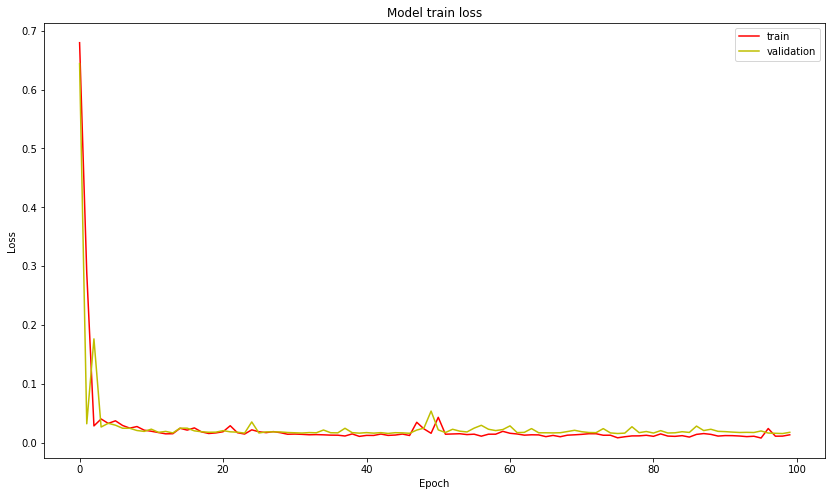

In [11]:
plt.figure(figsize=(14, 8))

plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'y')
plt.title('Model train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

## 20-4. 시맨틱 세그멘테이션 모델 시각화

In [10]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = float(intersection) / float(union) if union != 0 else 0.0
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

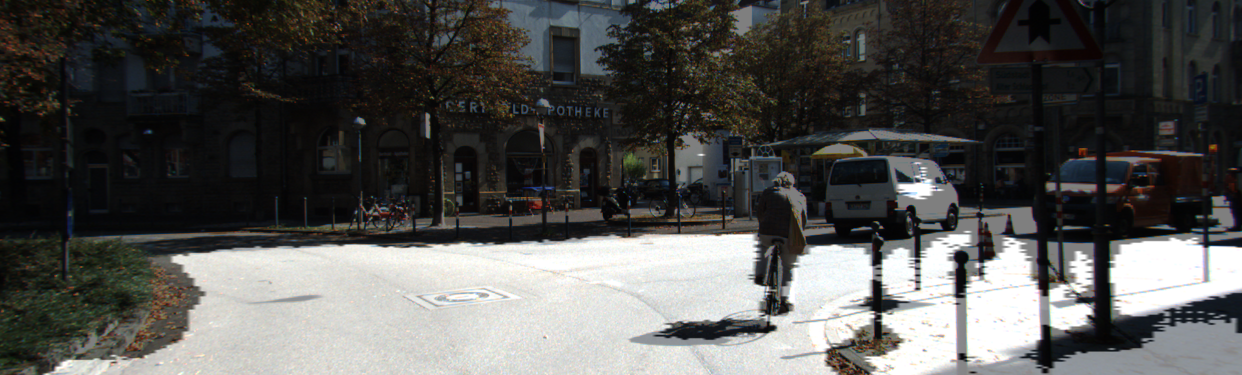

IoU : 0.608275


0.6082754054948692

In [14]:
i = 3
output, prediction, target = get_output(
     my_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

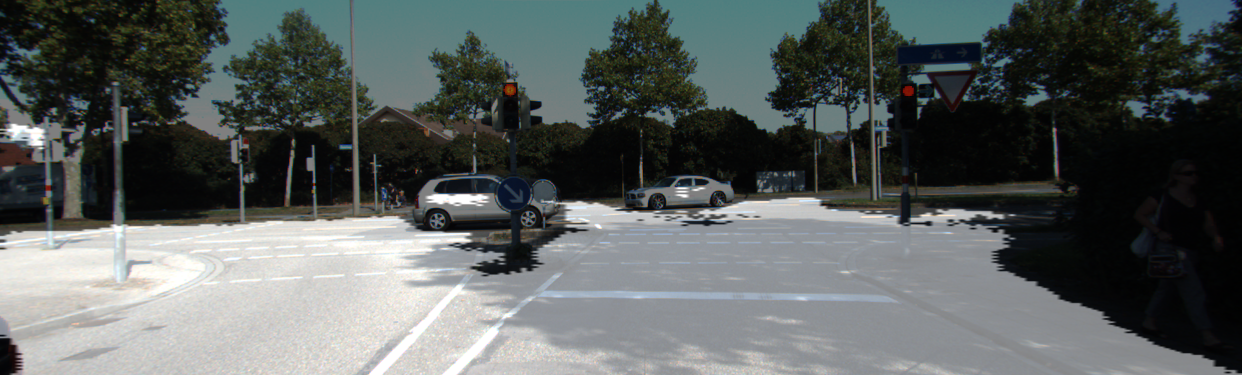

IoU : 0.734004


0.7340038053818972

In [13]:
i = 9
output, prediction, target = get_output(
     my_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

# 회고

## 결과
- 일반 Unet의 결과
    - nomal unet
        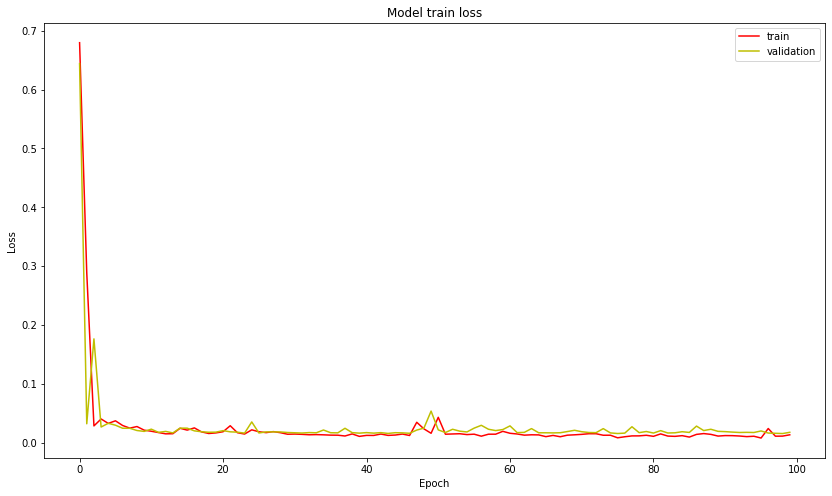
        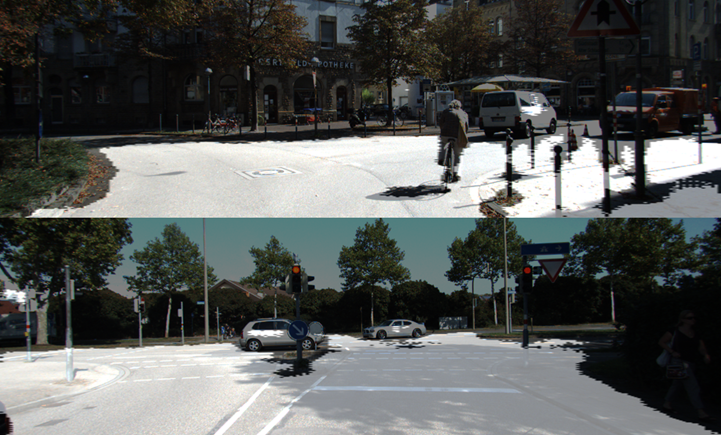
        - 6s 574ms/step - loss: 0.0134 - val_loss: 0.0177
        - IoU : 0.608275, IoU : 0.734004
- Unet++의 결과
    - only final loss
        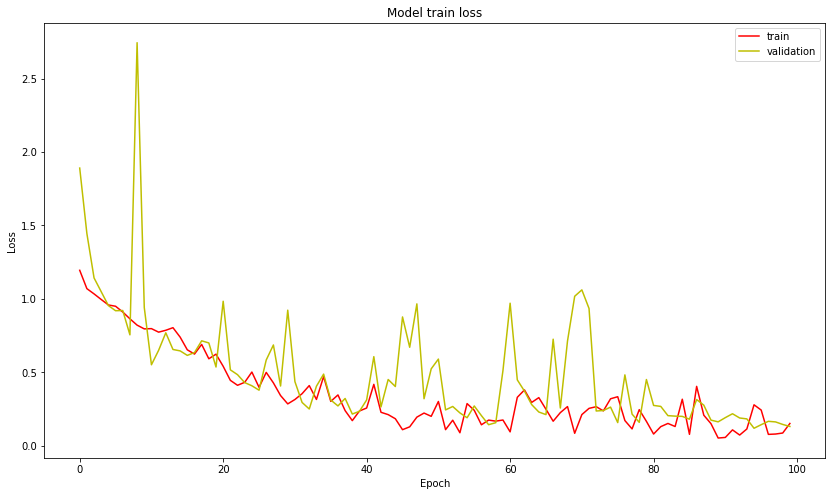
        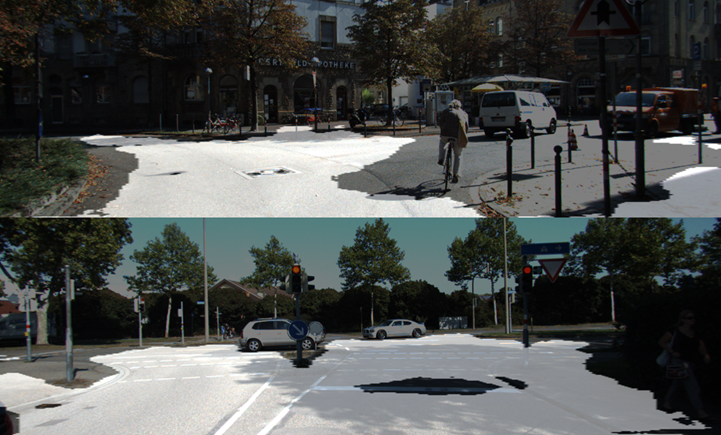
        - 12s 1s/step - loss: 0.1526 - val_loss: 0.1321
        - IoU : 0.547625, IoU : 0.717717
    - loss voting 1
        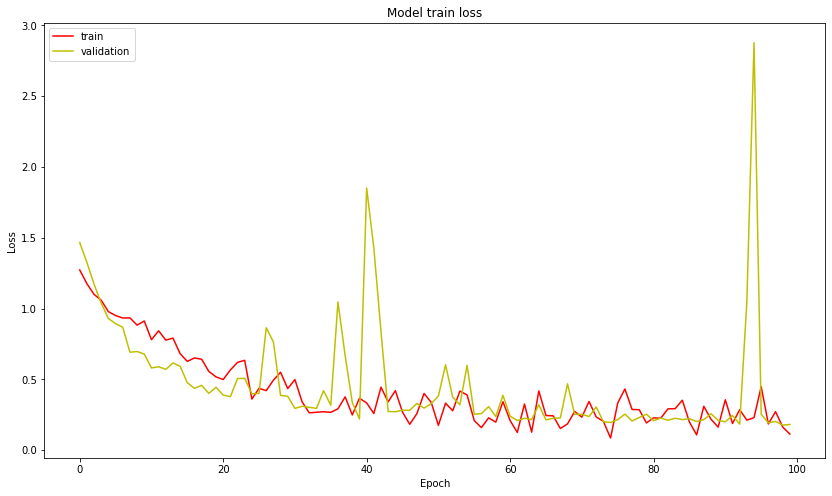
        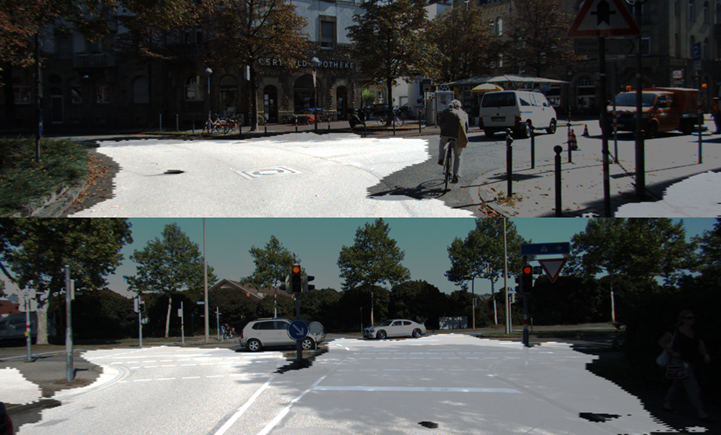
        - 12s 1s/step - loss: 0.1131 - val_loss: 0.1811
        - IoU : 0.629851, IoU : 0.757694
    - loss voting 2
        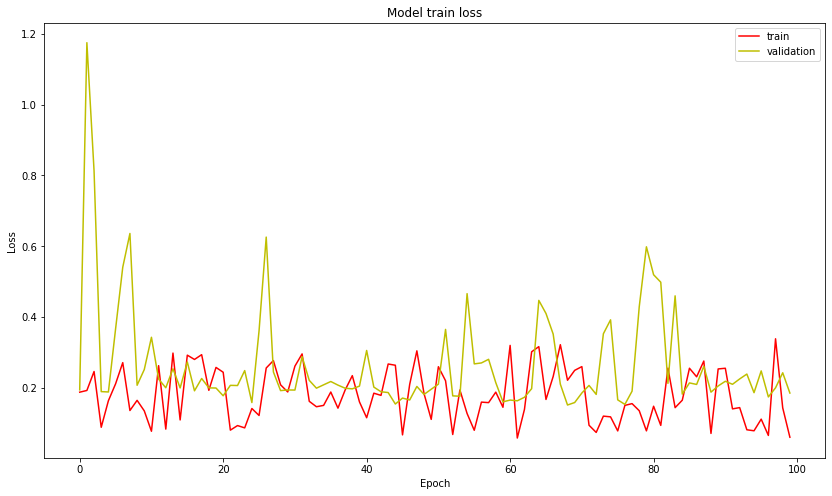
        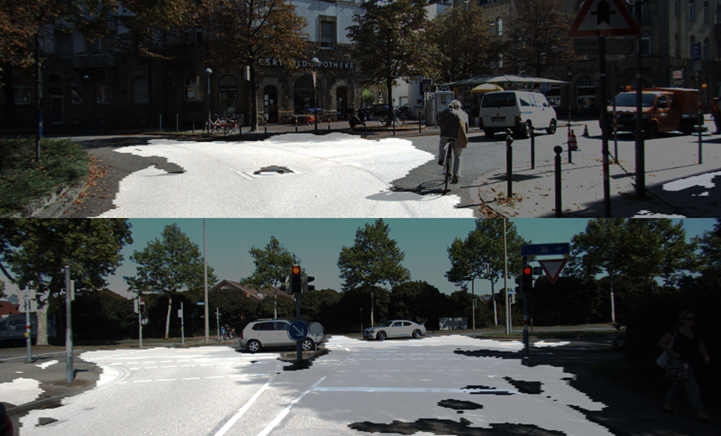
        - 12s 1s/step - loss: 0.0606 - val_loss: 0.1854
        - IoU : 0.633157, IoU : 0.768358
        
## 분석
- loss voting 2가 가장 높은 성능을 보였으나, 이미 성능 한계에 봉착한 것으로 확인됨
- epoch를 늘리면 loss voting 1이 더 높은 성능을 보일것으로 생각됨